<a href="https://colab.research.google.com/github/amitsiwach/Time_series_modelling/blob/main/ARIMA_Model_Forward_walk_prediction_on_share_price_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import datetime as dt
# import yahoo_finance as yf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
import numpy as np
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import plotly.express as px
import kaleido
from PIL import Image

import plotly.io as pio

In [6]:
def get_data():
    ticker = "CL=F"
    start_date = dt.datetime(2010,1,1)
    end_date = dt.datetime.today()
    data = yf.download(ticker, start = start_date, end =end_date)
    df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)   
    df = df.astype(float)
    return df
df = get_data()
mtly_return = df['Adj Close'].resample('M').mean().pct_change()

[*********************100%***********************]  1 of 1 completed


In [7]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04 00:00:00-05:00,79.629997,81.680000,79.629997,81.510002,81.510002,263542.0
2010-01-05 00:00:00-05:00,81.629997,82.000000,80.949997,81.769997,81.769997,258887.0
2010-01-06 00:00:00-05:00,81.430000,83.519997,80.849998,83.180000,83.180000,370059.0
2010-01-07 00:00:00-05:00,83.199997,83.360001,82.260002,82.660004,82.660004,246632.0
2010-01-08 00:00:00-05:00,82.650002,83.470001,81.800003,82.750000,82.750000,310377.0
...,...,...,...,...,...,...
2022-10-05 00:00:00-04:00,86.370003,88.419998,85.419998,87.760002,87.760002,329790.0
2022-10-06 00:00:00-04:00,88.080002,89.070000,87.040001,88.449997,88.449997,235296.0
2022-10-07 00:00:00-04:00,88.930000,93.309998,88.000000,92.639999,92.639999,429162.0


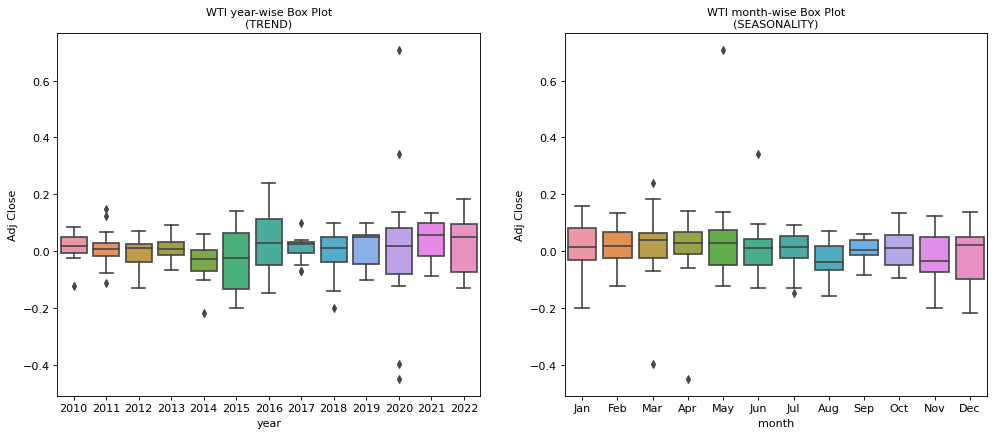

In [8]:
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime.today()
d = mtly_return.reset_index()

d['year'] = [i.year for i in d.Date]
d['month'] = [i.strftime('%b') for i in d.Date]
years = d['year'].unique()

fig, axes = plt.subplots(1, 2, figsize=(15,6), dpi= 80)
sns.boxplot(x='year', y='Adj Close', data=d, ax=axes[0])
sns.boxplot(x='month', y='Adj Close', data=d.loc[~d.year.isin([start_date, end_date]), :])

axes[0].set_title('WTI year-wise Box Plot\n(TREND)', fontsize=10); 
axes[1].set_title('WTI month-wise Box Plot\n(SEASONALITY)', fontsize=10)
plt.show()

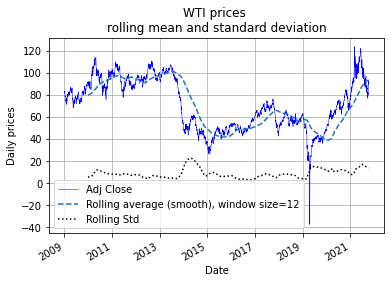

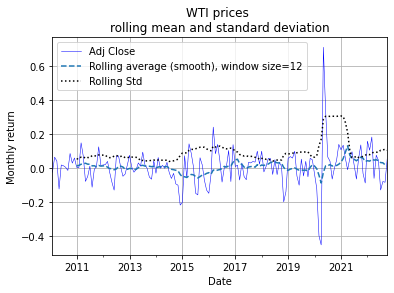

In [9]:
def rolling_statistics(ts, title, ylabel, window_size=12):
  ts.plot(style='-', color = 'blue',lw=0.5)
  ts.rolling(window_size).mean().plot(style='--', label='Rolling average (smooth), window size=12')
  ts.rolling(window_size).std().plot(style=':', color='black', label='Rolling Std')
  plt.legend(loc='best');  plt.ylabel(ylabel)
  plt.title(title); plt.grid(True)
  plt.show(block=False)
rolling_statistics(df['Adj Close'],'WTI prices \nrolling mean and standard deviation','Daily prices',252)
rolling_statistics(mtly_return[1:],'WTI prices \nrolling mean and standard deviation','Monthly return')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


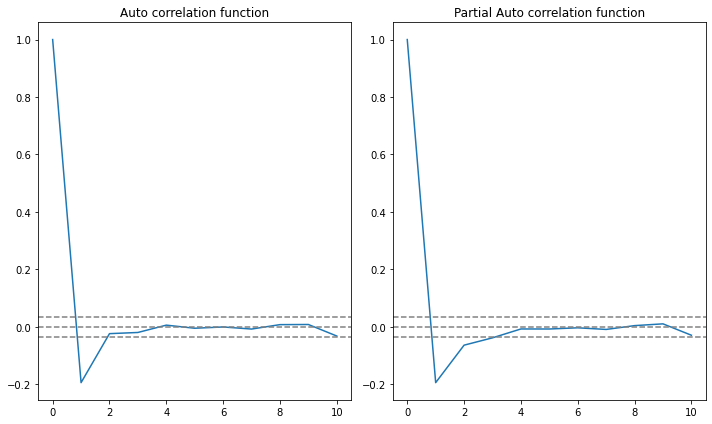

In [10]:
x = df["Adj Close"].copy()
x_diff = x.diff().dropna() # first item is NA

plt.figure(figsize = (10,6))
lag_acf = acf(x_diff, nlags=10)
lag_pacf = pacf(x_diff, nlags=10, method = 'ols')

# acf
plt.subplot(121); plt.plot(lag_acf);
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.title('Auto correlation function')

# pacf
plt.subplot(122); plt.plot(lag_pacf);
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.title('Partial Auto correlation function'); plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Autocorrelation Function')

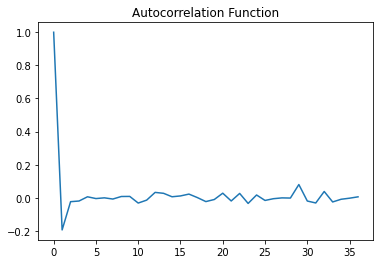

In [11]:
x_diff = x.diff().dropna() # first item is NA
lag_acf = acf(x_diff, nlags=36)
plt.plot(lag_acf)
plt.title('Autocorrelation Function')

In [12]:
def adf_test(series):
  print('Results of Dickey-Fuller Test:')
  adf_test = adfuller(series[1:], autolag='AIC')
  adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'pvalue',
                                              '#Lags Used', 'Number of Observations Used'])
  print (adf_output)

print('Stationarity_Daily data:')
print(adf_test(df['Adj Close'])); print()
print('Stationarity_differenced series:')
print(adf_test(x_diff))

Stationarity_Daily data:
Results of Dickey-Fuller Test:
Test Statistic                   -1.809267
pvalue                            0.375871
#Lags Used                        3.000000
Number of Observations Used    3211.000000
dtype: float64
None

Stationarity_differenced series:
Results of Dickey-Fuller Test:
Test Statistic                  -37.389144
pvalue                            0.000000
#Lags Used                        2.000000
Number of Observations Used    3211.000000
dtype: float64
None


In [13]:
!pip install hurst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import hurst 
from hurst import compute_Hc, random_walk
H, c, data = compute_Hc(
    x, 
    kind='random_walk', 
    simplified=True
    )
print(H, c)

0.5156525575467216 1.3068616895162435


In [15]:
size = int(len(x) * 0.90)
n_train = size
n_records = len(x)
for i in range(n_train, n_records):
  train, test = x[0:i], x[i:i+1]
  # print('train=%d, test=%d' % (len(train), len(test)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(1,1,1)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                           Adj Close  predictions_wf
Date                                                
2022-10-11 00:00:00-04:00  89.269997       91.073623


In [16]:
import warnings
from math import sqrt

# split into train and test sets
size = int(len(x) * 0.90)
train, test = x[0:size], x[size:len(x)]
# print(len(train)); len(test)) # 2377, 265

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(1,1,1)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                           Adj Close  predictions_wf
Date                                                
2021-07-07 00:00:00-04:00  72.199997       73.788691
2021-07-08 00:00:00-04:00  72.940002       72.642697
2021-07-09 00:00:00-04:00  74.559998       72.889276
2021-07-12 00:00:00-04:00  74.099998       74.115400
2021-07-13 00:00:00-04:00  75.250000       74.070777
...                              ...             ...
2022-10-05 00:00:00-04:00  87.760002       85.631428
2022-10-06 00:00:00-04:00  88.449997       87.166089
2022-10-07 00:00:00-04:00  92.639999       88.084191
2022-10-10 00:00:00-04:00  91.129997       91.636513
2022-10-11 00:00:00-04:00  89.269997       91.073623

[322 rows x 2 columns]


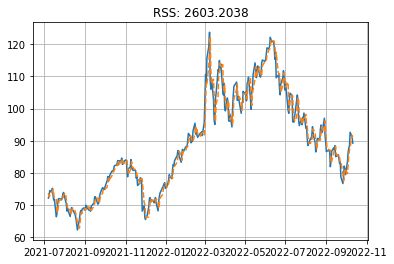

Test RMSE for ARIMA with Walk-Forward Validation:  2.843322680911179


In [17]:
plt.plot(test_['Adj Close'])
plt.plot(test_.predictions_wf, '--')
plt.title('RSS: %.4f'% sum((test_.predictions_wf - test_['Adj Close'])**2))
plt.grid(True);plt.show()
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARIMA with Walk-Forward Validation: ', error)

In [18]:
fig = px.line(test_,
              y=['Adj Close','predictions_wf'], x = test_.index,
              title='custom tick labels')

fig


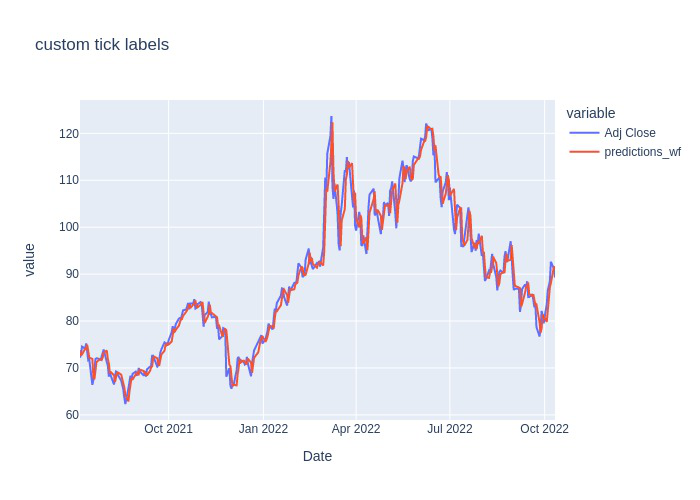

In [19]:
pio.write_image(fig,"Actual vs Predicted on blog data.jpg", format='jpg')
Image.open("Actual vs Predicted on blog data.jpg")

In [20]:
test_.index

DatetimeIndex(['2021-07-07 00:00:00-04:00', '2021-07-08 00:00:00-04:00',
               '2021-07-09 00:00:00-04:00', '2021-07-12 00:00:00-04:00',
               '2021-07-13 00:00:00-04:00', '2021-07-14 00:00:00-04:00',
               '2021-07-15 00:00:00-04:00', '2021-07-16 00:00:00-04:00',
               '2021-07-19 00:00:00-04:00', '2021-07-20 00:00:00-04:00',
               ...
               '2022-09-28 00:00:00-04:00', '2022-09-29 00:00:00-04:00',
               '2022-09-30 00:00:00-04:00', '2022-10-03 00:00:00-04:00',
               '2022-10-04 00:00:00-04:00', '2022-10-05 00:00:00-04:00',
               '2022-10-06 00:00:00-04:00', '2022-10-07 00:00:00-04:00',
               '2022-10-10 00:00:00-04:00', '2022-10-11 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=322, freq=None)

In [21]:
max(train.values), min(train.values)

(113.93000030517578, -37.630001068115234)

In [22]:
max(test.values), min(test.values)

(123.69999694824219, 62.31999969482422)

In [23]:
type(train.values)

numpy.ndarray

In [24]:
# pd.DataFrame(train.index,train.values).to_csv("train_data.csv")
# pd.DataFrame(test.index,test.values).to_csv("test_data.csv")